In [1]:
import sys, os; sys.path.append(os.path.abspath(".."))
import pandas as pd
import numpy as np
import statsmodels.api as sm

from src.io_utils import load_parquet
from src.pipelines import make_linear_pipe, make_tree_pipe
from src.encoders import build_preprocessor
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import time

# Load prepared data

X_final = load_parquet("../data/interim/X_final.parquet")
transformed_df = load_parquet("../data/interim/transformed_df.parquet")
y = load_parquet("../data/interim/target.parquet")["SalePrice"]
X_fe = load_parquet("../data/interim/X_fe.parquet")
# your existing linear evaluation/tuning helpers can be reused here
# (paste your cv_eval_models + tune/eval code or import your module if you wrapped it)

In [2]:
def univariate_linreg_statsmodels(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    log_target: bool = False
) -> pd.DataFrame:
    """
    Runs separate OLS for each single feature vs. y.
    If log_target=True, fits on log1p(y) and reports RMSE in dollars (back-transformed).
    Coefficients and intercept are reported in the model's native space
    (log-price when log_target=True; raw dollars otherwise).
    """
    rows = []
    y_array = np.asarray(y)
    y_trainable = np.log1p(y_array) if log_target else y_array  # training target

    for col in X.columns:
        x = X[[col]]
        if np.allclose(x.values.std(), 0):
            # constant feature: skip fit/metrics
            rows.append({
                "feature": col,
                "r2": np.nan,
                "rmse": np.nan,
                "coef": 0.0,
                "intercept": float(np.mean(y_trainable)),
                "p_value": np.nan,
                "coef_ci_low": np.nan,
                "coef_ci_high": np.nan,
                "fitted_on_log_target": bool(log_target)
            })
            continue

        Xc = sm.add_constant(x, has_constant="add")
        model = sm.OLS(y_trainable, Xc).fit()

        # Predictions in training space
        y_pred_train_space = model.predict(Xc)

        # RMSE: report in dollars if we trained in log space
        if log_target:
            y_pred_dollars = np.expm1(y_pred_train_space)
            rmse = float(np.sqrt(((y_array - y_pred_dollars) ** 2).mean()))
        else:
            rmse = float(np.sqrt(((y_array - y_pred_train_space) ** 2).mean()))

        coef = float(model.params[col])
        ci_low, ci_high = model.conf_int().loc[col].tolist()
        p = float(model.pvalues[col])

        rows.append({
            "feature": col,
            "r2": float(model.rsquared),
            "rmse": rmse,
            "coef": coef,
            "intercept": float(model.params["const"]),
            "p_value": p,
            "coef_ci_low": float(ci_low),
            "coef_ci_high": float(ci_high),
            "fitted_on_log_target": bool(log_target)
        })

    out = pd.DataFrame(rows).sort_values("r2", ascending=False).reset_index(drop=True)
    return out

In [3]:
results_df = univariate_linreg_statsmodels(X_final, y, log_target=True)

results_df.head(10)

,feature,r2,rmse,coef,intercept,p_value,coef_ci_low,coef_ci_high,fitted_on_log_target
0,TotalSF_x_Qual,0.766159,57699.093658,0.000043,11.325574,0.0,0.000042,0.000044,True
1,GrLivArea_x_Qual,0.699238,59613.552871,0.000069,11.367974,0.0,0.000067,0.000071,True
2,OverallQual,0.665792,42826.954278,0.315983,12.013480,0.0,0.307337,0.324629,True
3,TotalSF,0.663846,43895.469032,0.315521,12.013480,0.0,0.306850,0.324192,True
4,Baths_x_Garage,0.571950,78464.970427,0.106084,11.573491,0.0,0.102540,0.109629,True
5,GrLivArea,0.532934,53117.216109,0.282703,12.013480,0.0,0.272482,0.292924,True
6,TotalBaths,0.448866,60769.294082,0.259450,12.013480,0.0,0.248347,0.270553,True
7,GarageCars,0.444250,57561.676722,0.258112,12.013480,0.0,0.246963,0.269261,True
8,ExterQual,0.443678,54418.774564,0.460922,10.920666,0.0,0.440989,0.480855,True
9,GrLiv_per_Room,0.438351,59802.057544,0.006401,10.739935,0.0,0.006122,0.006681,True


<Axes: xlabel='TotalSF'>

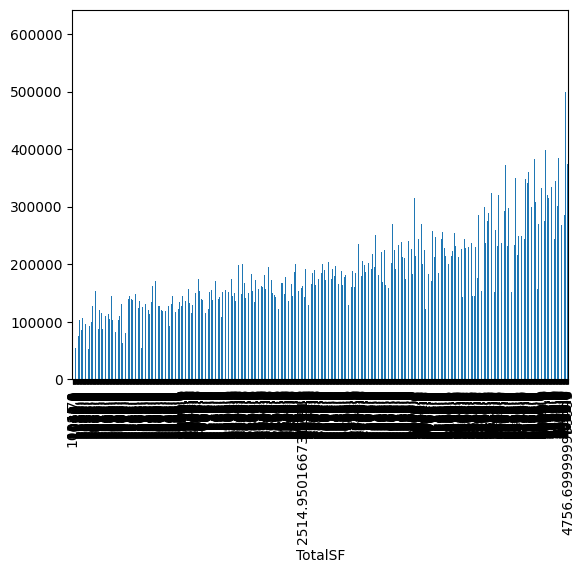

In [4]:
pd.concat([transformed_df, y], axis = 1).groupby(results_df.feature[3])['SalePrice'].mean().plot(kind="bar")

In [5]:


# --- Helpers ---
def rmse_compat(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)  # works across sklearn versions
    return float(np.sqrt(mse))

def get_feature_names(X):
    if hasattr(X, "columns"):
        return list(X.columns)
    return [f"x{i}" for i in range(X.shape[1])]

# --- Main ---
def fit_multiple_linreg_all_features(
    X, y, *, test_size=0.2, random_state=42, n_splits=5, log_target=False
):
    """
    X: preprocessed feature matrix (DataFrame or ndarray), no NaNs
    y: target Series/array (SalePrice)
    log_target: if True, fits on log1p(y) and reports back-transformed RMSE too
    """
    feature_names = get_feature_names(X)

    # Target transform (optional)
    if log_target:
        y_trainable = np.log1p(y)
    else:
        y_trainable = np.asarray(y)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_trainable, test_size=test_size, random_state=random_state
    )

    # Fit
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Predict
    y_pred_test = lr.predict(X_test)
    y_pred_train = lr.predict(X_train)

    # Metrics (in target space)
    if log_target:
        # Back-transform for error metrics in dollars
        y_test_dollars = np.expm1(y_test)
        y_pred_test_dollars = np.expm1(y_pred_test)
        test_rmse = rmse_compat(y_test_dollars, y_pred_test_dollars)
        test_r2 = r2_score(y_test_dollars, y_pred_test_dollars)
    else:
        test_rmse = rmse_compat(y_test, y_pred_test)
        test_r2 = float(r2_score(y_test, y_pred_test))

    # Cross-validated RMSE (on full data)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    neg_mse = cross_val_score(lr, X, y_trainable, scoring="neg_mean_squared_error", cv=cv)
    if log_target:
        # Back-transform each fold's MSE is not available; report in log space as approx
        cv_rmse = float(np.sqrt(-neg_mse).mean())
        cv_rmse_std = float(np.sqrt(-neg_mse).std())
    else:
        cv_rmse = float(np.sqrt(-neg_mse).mean())
        cv_rmse_std = float(np.sqrt(-neg_mse).std())

    # Coefficients
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coef": lr.coef_,
        "abs_coef": np.abs(lr.coef_)
    }).sort_values("abs_coef", ascending=False).reset_index(drop=True)

    metrics = {
        "test_rmse": test_rmse,
        "test_r2": test_r2,
        "cv_rmse_mean": cv_rmse,
        "cv_rmse_std": cv_rmse_std,
        "intercept": float(lr.intercept_),
        "fitted_on_log_target": bool(log_target),
    }

    # Also return out-of-sample predictions (useful for residual checks)
    outputs = {
        "y_test_pred": y_pred_test if not log_target else y_pred_test_dollars,
        "y_test_true": y_test if not log_target else y_test_dollars,
    }

    return lr, coef_df, metrics, outputs

In [6]:
lr, coef_df, metrics, out = fit_multiple_linreg_all_features(X_final, y, log_target=True)
print(metrics)

{'test_rmse': 23261.412138335647, 'test_r2': 0.9120414837155251, 'cv_rmse_mean': 0.11078630969961605, 'cv_rmse_std': 0.014307253168654588, 'intercept': 10.450882556535811, 'fitted_on_log_target': True}


In [2]:
RANDOM_STATE = 42
CV_FOLDS = 5

# =========================
# 1) Utilities
# =========================
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def cv_eval_models(X, y, models, *, cv=CV_FOLDS, log_target=False, random_state=RANDOM_STATE):
    """
    Cross-validated evaluation with optional log-target training and dollar-scale metrics.

    Returns a DataFrame with:
      - cv_rmse_mean / cv_rmse_std  (in $)
      - r2_cv   (OOF R², in $)
      - r2_full (fit-on-all-data R², in $)
    """
    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    rows = []
    for name, model in models:
        fold_rmses = []
        oof_pred = np.zeros(len(y_np), dtype=float)

        for tr_idx, va_idx in kf.split(X):
            X_tr, X_va = (X.iloc[tr_idx], X.iloc[va_idx]) if hasattr(X, "iloc") else (X[tr_idx], X[va_idx])
            y_tr, y_va = y_np[tr_idx], y_np[va_idx]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            model.fit(X_tr, y_tr_used)

            y_va_pred = model.predict(X_va)
            if log_target:
                y_va_pred = np.expm1(y_va_pred)

            fold_rmses.append(rmse(y_va, y_va_pred))
            oof_pred[va_idx] = y_va_pred

        r2_cv = r2_score(y_np, oof_pred)

        # Full-fit R² in $-space
        y_full_used = np.log1p(y_np) if log_target else y_np
        model.fit(X, y_full_used)
        y_full_pred = model.predict(X)
        if log_target:
            y_full_pred = np.expm1(y_full_pred)
        r2_full = r2_score(y_np, y_full_pred)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_cv),
            "r2_full": float(r2_full),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

# =========================
# 2) Penalized models: fit + interpretable coefs
# =========================
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV
from sklearn.model_selection import KFold

def evaluate_penalized_models_stable(
    X, y, *,
    log_target=True,
    random_state=RANDOM_STATE,
    top_n=50,
    min_pct=5.0,
    include_full=False
):
    """
    Fits RidgeCV, LassoCV, ElasticNetCV. Returns metrics and filtered coef tables
    with % change (if log_target), feature types, and coverage.
    Keeps all numeric features and one-hot features present in ≥ min_pct of homes.
    """
    y_array = np.asarray(y)
    y_trainable = np.log1p(y_array) if log_target else y_array

    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
    alphas = np.logspace(-3, 3, 50)
    # alphas = np.logspace(-4, 4, 80)
    l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

    ridge = RidgeCV(alphas=alphas, cv=cv, scoring="neg_mean_squared_error").fit(X, y_trainable)
    lasso = LassoCV(alphas=alphas, cv=cv, random_state=random_state, max_iter=100_000, tol=1e-3).fit(X, y_trainable)
    enet  = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=cv,
                         random_state=random_state, max_iter=100_000, tol=1e-3).fit(X, y_trainable)

    def _metrics(name, model, y_true, y_pred_train_space):
        if log_target:
            y_pred = np.expm1(y_pred_train_space)
            return {"model": name,
                    "alpha": getattr(model, "alpha_", None),
                    "l1_ratio": getattr(model, "l1_ratio_", None),
                    "rmse": rmse(y_true, y_pred),
                    "r2": float(r2_score(y_true, y_pred))}
        else:
            return {"model": name,
                    "alpha": getattr(model, "alpha_", None),
                    "l1_ratio": getattr(model, "l1_ratio_", None),
                    "rmse": rmse(y_true, y_pred_train_space),
                    "r2": float(r2_score(y_true, y_pred_train_space))}

    results = pd.DataFrame([
        _metrics("Ridge",      ridge, y_array, ridge.predict(X)),
        _metrics("Lasso",      lasso, y_array, lasso.predict(X)),
        _metrics("ElasticNet", enet,  y_array, enet.predict(X)),
    ])

    # coef tables
    feats = list(X.columns) if hasattr(X, "columns") else [f"x{i}" for i in range(X.shape[1])]

    def _coef_table(model):
        coef = np.asarray(model.coef_)
        df = pd.DataFrame({"feature": feats, "coef": coef})
        df["abs_coef"] = df["coef"].abs()
        return df.sort_values("abs_coef", ascending=False).head(top_n).reset_index(drop=True)

    raw_tables = {"Ridge": _coef_table(ridge), "Lasso": _coef_table(lasso), "ElasticNet": _coef_table(enet)}

    # feature typing & coverage
    def _is_one_hot(col: pd.Series) -> bool:
        vals = pd.unique(col.dropna())
        return set(np.asarray(vals)).issubset({0, 1, 0.0, 1.0})

    if hasattr(X, "columns"):
        n = len(X)
        is_dummy = {c: _is_one_hot(X[c]) for c in X.columns}
        coverage = {}
        for c in X.columns:
            if is_dummy[c]:
                col = X[c]
                # robust if any scaling slipped in
                cov = (col > 0.5).mean() if (np.issubdtype(col.dtype, np.number) and (col.max() > 1 or col.min() < 0)) else col.mean()
                coverage[c] = float(cov) * 100.0
            else:
                coverage[c] = 100.0
    else:
        is_dummy, coverage = {}, {}

    def _augment_and_filter(df):
        out = df.copy()
        out["pct_change"] = (np.exp(out["coef"]) - 1.0) * 100.0 if log_target else np.nan
        if hasattr(X, "columns"):
            out["feature_type"] = out["feature"].map(lambda f: "one-hot categorical" if is_dummy.get(f, False) else "numeric")
            out["pct_of_data"]  = out["feature"].map(lambda f: coverage.get(f, np.nan))
        else:
            out["feature_type"] = "unknown"; out["pct_of_data"] = np.nan
        mask = (out["feature_type"] == "numeric") | (out["pct_of_data"] >= min_pct)
        out = out[mask].copy()
        out = out.reindex(out[( "pct_change" if log_target else "abs_coef")].abs().sort_values(ascending=False).index)
        return out.reset_index(drop=True)

    filtered_tables = {name: _augment_and_filter(df) for name, df in raw_tables.items()}

    if include_full:
        return results, filtered_tables, raw_tables
    else:
        return results, filtered_tables

# =========================
# 3) Consensus table & plot (penalized models)
# =========================
def build_consensus_table(ridge_df: pd.DataFrame,
                          lasso_df: pd.DataFrame,
                          enet_df: pd.DataFrame,
                          min_models: int = 2) -> pd.DataFrame:
    def _prep(df, tag):
        return df[["feature", "feature_type", "pct_change", "pct_of_data"]].rename(
            columns={"pct_change": f"{tag}_pct", "pct_of_data": f"{tag}_pct_of_data"}
        )
    merged = _prep(ridge_df, "Ridge").merge(_prep(lasso_df, "Lasso"), on=["feature","feature_type"], how="outer") \
                                     .merge(_prep(enet_df, "ElasticNet"), on=["feature","feature_type"], how="outer")
    model_cols = ["Ridge_pct", "Lasso_pct", "ElasticNet_pct"]
    merged["n_models"] = merged[model_cols].notna().sum(axis=1)
    merged = merged[merged["n_models"] >= min_models].copy()
    merged["avg_pct_change"] = merged[model_cols].mean(axis=1, skipna=True)
    merged["std_pct_change"] = merged[model_cols].std(axis=1, ddof=0, skipna=True)
    coverage_cols = ["Ridge_pct_of_data", "Lasso_pct_of_data", "ElasticNet_pct_of_data"]
    merged["pct_of_data"] = merged[coverage_cols].max(axis=1, skipna=True)
    return merged.sort_values("avg_pct_change", key=lambda s: s.abs(), ascending=False).reset_index(drop=True)

def plot_consensus_bar(consensus_df: pd.DataFrame, top_n: int = 15, with_errorbars: bool = True, figsize=(9,6),
                       title="Consensus Feature Importance (Penalized Models)"):
    df = consensus_df.head(top_n).copy().sort_values("avg_pct_change", ascending=True)
    plt.figure(figsize=figsize)
    bars = plt.barh(df["feature"], df["avg_pct_change"])
    for b, val in zip(bars, df["avg_pct_change"]):
        b.set_color("tab:red" if val < 0 else "tab:green")
    if with_errorbars and "std_pct_change" in df.columns:
        x = df["avg_pct_change"].values
        err = df["std_pct_change"].fillna(0).values
        y = np.arange(len(df))
        plt.errorbar(x, y, xerr=err, fmt="none", ecolor="gray", capsize=3, linewidth=1)
    plt.axvline(0, color="black", lw=0.8)
    plt.xlabel("Average % Change in Price (per 1 SD or category)")
    plt.ylabel("Feature")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# =========================
# 4) Models & example usage
# =========================
# NOTE:
# - Use X_final (scaled numerics) for linear models; use X_raw (unscaled) for trees if you have it.
# - y_final should be RAW SalePrice; set log_target=True to train in log space with $-scale metrics.

alphas = np.logspace(-3, 1, 40)
l1_grid = [0.1, 0.3, 0.5, 0.7, 0.9]

# models = [
#     ("Ridge",        Ridge(alpha=14.56)),
#     ("LassoCV",      LassoCV(alphas=alphas, cv=CV_FOLDS, max_iter=100_000, tol=1e-3, n_jobs=-1)),
#     ("ElasticNetCV", ElasticNetCV(alphas=alphas, l1_ratio=l1_grid, cv=CV_FOLDS, max_iter=100_000, tol=1e-3, random_state=RANDOM_STATE)),
#     ("RandomForest", RandomForestRegressor(n_estimators=500, random_state=RANDOM_STATE, n_jobs=1)),  # avoid nested parallel
#     ("HistGB",       HistGradientBoostingRegressor(random_state=RANDOM_STATE)),
#     ("SVR",          SVR(kernel='rbf', C=10, epsilon=0.2)),
# ]


models = [
    ("Ridge",        RidgeCV(alphas=alphas, cv=CV_FOLDS, scoring="neg_mean_squared_error")),
    ("LassoCV",      LassoCV(alphas=alphas, cv=CV_FOLDS, max_iter=100_000, tol=1e-3, n_jobs=-1)),
    ("ElasticNetCV", ElasticNetCV(alphas=alphas, l1_ratio=l1_grid, cv=CV_FOLDS, max_iter=100_000, tol=1e-3, random_state=RANDOM_STATE)),
]

In [8]:

# --- Penalized models + consensus (log target recommended) ---
results_df, coef_tables = evaluate_penalized_models_stable(X_final, y, log_target=True, min_pct=5, top_n=200)
print(results_df)

y_final = y

s= time.time()
print("\n=== LOG target leaderboard ===")
print(cv_eval_models(X_final, y_final, models, cv=CV_FOLDS, log_target=True,  random_state=RANDOM_STATE).to_string(index=False))

print((time.time() -s), 'sec')

        model      alpha  l1_ratio          rmse        r2
0       Ridge  19.306977       NaN  18600.813512  0.938518
1       Lasso   0.001000       NaN  21144.321606  0.920554
2  ElasticNet   0.001758       0.1  18745.703034  0.937556

=== LOG target leaderboard ===
       model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
       Ridge  21950.781370  5734.168758 0.908535 0.941019
ElasticNetCV  22277.443849  5848.627610 0.905732 0.936459
     LassoCV  23478.507371  7119.384355 0.893038 0.920554
20.712148904800415 sec


In [9]:
import time
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
# uses your existing: cv_eval_models(X, y, models, ...)

t0 = time.time()
RANDOM_STATE = 42
CV_OUTER = 10  # outer folds in your cv_eval_models

# --- compact, targeted inner search spaces ---
ridge_alphas = np.linspace(8, 20, 13)              # around your best ~12
lasso_alphas = np.r_[np.logspace(-4, -3, 5),       # 1e-4 … 1e-3
                     np.linspace(0.0012, 0.01, 8)] # densify near prior best
enet_alphas  = lasso_alphas
enet_l1      = [0.2, 0.4, 0.6]                     # slim but representative
# enet_l1 = np.linspace(0.2, 0.9, 8)  # denser sweep

# --- fast inner CV configs ---
ridge_fast = RidgeCV(alphas=ridge_alphas, cv=None)  # GCV = fast & accurate
inner5 = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

lasso_fast = LassoCV(
    alphas=lasso_alphas, cv=inner5,
    max_iter=100_000, tol=1e-3, random_state=RANDOM_STATE, n_jobs=-1
)

enet_fast  = ElasticNetCV(
    alphas=enet_alphas, l1_ratio=enet_l1, cv=inner5,
    max_iter=100_000, tol=1e-3, random_state=RANDOM_STATE, n_jobs=-1
)

models = [
    ("Ridge",        ridge_fast),
    ("LassoCV",      lasso_fast),
    ("ElasticNetCV", enet_fast),
]

print("\n=== LOG target leaderboard (lean inner-CV) ===")
print(cv_eval_models(X_final, y, models, cv=CV_OUTER, log_target=True,
                     random_state=RANDOM_STATE).to_string(index=False))

print(f"\nElapsed: {(time.time()-t0):.2f} sec")


=== LOG target leaderboard (lean inner-CV) ===
       model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
       Ridge  21263.565907  7149.501932 0.910572 0.939283
ElasticNetCV  21681.541834  7323.775570 0.906934 0.936121
     LassoCV  21847.123985  7461.594298 0.905291 0.934641

Elapsed: 44.69 sec


In [3]:
# in your notebook
from src.pipelines import make_linear_pipe, make_tree_pipe

log_cols = [
    "LotArea","LotFrontage","MasVnrArea",
    "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
    "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
    "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
    "3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea"
]

scale_features = [
    # continuous
    "GrLivArea","LotFrontage","LotArea","MasVnrArea",
    "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
    "1stFlrSF","2ndFlrSF","LowQualFinSF","GarageArea",
    "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
    "ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
    # counts
    "BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
    "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd",
    "Fireplaces","GarageCars","TotalBaths",
    # ordinals
    "OverallQual","OverallCond",
    # years/ages
    "YearBuilt","YearRemodAdd","GarageYrBlt",
    "HouseAge","HouseAgeSinceRemod","GarageAge",
]

CAP_COLS = [
    "LotArea","LotFrontage","MasVnrArea","TotalBsmtSF","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
    "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
    "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal"
]

# X_fe: engineered dataframe (no manual capping/scaling outside the pipeline)
# y = Ames["SalePrice"]

models = [
    ("Ridge (log+cap+scale)", make_linear_pipe(
        X_fe, model="ridge", model_kwargs=dict(alpha=12.0),
        numeric_cap_cols=CAP_COLS, lower_q=0.01, upper_q=0.99,
        log_cols=log_cols, scale_features=scale_features,
        zero_impute_cols=("BsmtFullBath","BsmtHalfBath"),
        log_target=True, densify=False
    )),
    ("ElasticNet (log+cap+scale)", make_linear_pipe(
        X_fe, model="enet", model_kwargs=dict(alpha=0.001, l1_ratio=0.2),
        numeric_cap_cols=CAP_COLS, lower_q=0.01, upper_q=0.99,
        log_cols=log_cols, scale_features=scale_features,
        zero_impute_cols=("BsmtFullBath","BsmtHalfBath"),
        log_target=True, densify=True
    )),
    ("HistGB (cap only, no feature scaling)", make_tree_pipe(
        X_fe, model="histgb",
        model_kwargs=dict(max_depth=6, max_iter=1200, learning_rate=0.05),
        numeric_cap_cols=CAP_COLS, lower_q=0.01, upper_q=0.99,
        log_cols=[],                    # usually skip log(feature) for trees first
        scale_features=[],              # trees don’t need scaling
        zero_impute_cols=("BsmtFullBath","BsmtHalfBath"),
        log_target=True
    )),
]

# IMPORTANT: log_target=False here because TTR wraps the models.
print(cv_eval_models(
    X=X_fe, y=y, models=models, cv=5, log_target=False, random_state=42
).to_string(index=False))

/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self.lower_, self.upper_, axis=1)
/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self

                                model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
HistGB (cap only, no feature scaling)  21664.995445  3176.736904 0.914800 0.997877
                Ridge (log+cap+scale)  22151.202250  6337.005436 0.905671 0.938200
           ElasticNet (log+cap+scale)  22556.370572  6738.490534 0.901520 0.936149


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet

LOG_COLS = log_cols
SCALE_FEATURES = scale_features
zero_impute_cols=("BsmtFullBath","BsmtHalfBath")
ZERO_IMPUTE_COLS = zero_impute_cols

# Example: Ridge
ridge_pipe = Pipeline([
    ("prep", build_preprocessor(
        X_fe,
        numeric_cap=CAP_COLS,
        lower_q=0.01, upper_q=0.99,
        log_cols=LOG_COLS,
        scale_features=SCALE_FEATURES,
        zero_impute_cols=ZERO_IMPUTE_COLS
    )),
    ("ridge", Ridge())
])

ridge_grid = {
    "ridge__alpha": [0.1, 1, 5, 10, 20, 50, 100, 200]
}

ridge_search = GridSearchCV(
    ridge_pipe,
    ridge_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
ridge_search.fit(X_fe, y)

print("Best Ridge alpha:", ridge_search.best_params_)
print("Best Ridge CV score:", -ridge_search.best_score_)

/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self.lower_, self.upper_, axis=1)
/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self

Best Ridge alpha: {'ridge__alpha': 20}
Best Ridge CV score: 22370.489141025388


/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self.lower_, self.upper_, axis=1)
/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self

In [11]:
lasso_pipe = Pipeline([
    ("prep", build_preprocessor(
        X_fe,
        numeric_cap=CAP_COLS,
        lower_q=0.01, upper_q=0.99,
        log_cols=LOG_COLS,
        scale_features=SCALE_FEATURES,
        zero_impute_cols=ZERO_IMPUTE_COLS
    )),
    ("lasso", Lasso(max_iter=20000))
])

lasso_grid = {
    "lasso__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50]
}

lasso_search = GridSearchCV(
    lasso_pipe,
    lasso_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
lasso_search.fit(X_fe, y)

print("Best Lasso alpha:", lasso_search.best_params_)
print("Best Lasso CV score:", -lasso_search.best_score_)

/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self.lower_, self.upper_, axis=1)
/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self

Best Lasso alpha: {'lasso__alpha': 50}
Best Lasso CV score: 22555.728048975998


In [12]:
enet_pipe = Pipeline([
    ("prep", build_preprocessor(
        X_fe,
        numeric_cap=CAP_COLS,
        lower_q=0.01, upper_q=0.99,
        log_cols=LOG_COLS,
        scale_features=SCALE_FEATURES,
        zero_impute_cols=ZERO_IMPUTE_COLS
    )),
    ("enet", ElasticNet(max_iter=20000))
])

enet_grid = {
    "enet__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "enet__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1.0]
}

enet_search = GridSearchCV(
    enet_pipe,
    enet_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
enet_search.fit(X_fe, y)

print("Best ElasticNet params:", enet_search.best_params_)
print("Best ElasticNet CV score:", -enet_search.best_score_)

/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self.lower_, self.upper_, axis=1)
/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self

Best ElasticNet params: {'enet__alpha': 0.1, 'enet__l1_ratio': 0.9}
Best ElasticNet CV score: 22368.97033618117


In [13]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb_pipe = Pipeline([
    ("prep", build_preprocessor(
        X_fe,
        numeric_cap=CAP_COLS,
        lower_q=0.01, upper_q=0.99,
        zero_impute_cols=ZERO_IMPUTE_COLS
    )),
    ("hgb", HistGradientBoostingRegressor(random_state=42))
])

hgb_grid = {
    "hgb__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "hgb__max_depth": [3, 5, 7, None],
    "hgb__max_leaf_nodes": [15, 31, 63, 127],
    "hgb__min_samples_leaf": [5, 10, 20]
}

hgb_search = GridSearchCV(
    hgb_pipe,
    hgb_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
hgb_search.fit(X_fe, y)

print("Best HGB params:", hgb_search.best_params_)
print("Best HGB CV score:", -hgb_search.best_score_)

/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self.lower_, self.upper_, axis=1)
/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self

Best HGB params: {'hgb__learning_rate': 0.1, 'hgb__max_depth': 5, 'hgb__max_leaf_nodes': 15, 'hgb__min_samples_leaf': 10}
Best HGB CV score: 21229.47366208552


In [14]:
from dataclasses import dataclass
from typing import Dict, Callable, Tuple, List
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

@dataclass
class TunerSpec:
    """What to tune and how to build the pipeline."""
    name: str
    build_pipe: Callable[[], object]      # returns a fresh Pipeline (prep + model)
    param_grid: Dict[str, list]           # params for Grid/RandomizedSearchCV
    randomized: bool = False
    n_iter: int = 20                      # only used when randomized=True
    scoring: str = "neg_root_mean_squared_error"
    inner_cv_splits: int = 5

def cv_eval_models_nested(
    X, y,
    tuner_specs: List[TunerSpec],
    *,
    cv_outer_splits: int = 5,
    random_state: int = 42,
) -> Tuple[pd.DataFrame, Dict[str, List[Dict[str, object]]]]:
    """
    Nested CV:
      - For each outer fold: tune params on the training fold (inner CV), score on valid fold.
      - Returns a leaderboard and per-fold best params for each model.
    """
    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf_outer = KFold(n_splits=cv_outer_splits, shuffle=True, random_state=random_state)

    rows = []
    best_params_by_model: Dict[str, List[Dict[str, object]]] = {ts.name: [] for ts in tuner_specs}

    for ts in tuner_specs:
        oof_pred = np.zeros(len(y_np), dtype=float)
        fold_rmses = []
        fold_best_params = []

        for tr_idx, va_idx in kf_outer.split(X):
            X_tr = X.iloc[tr_idx] if hasattr(X, "iloc") else X[tr_idx]
            X_va = X.iloc[va_idx] if hasattr(X, "iloc") else X[va_idx]
            y_tr, y_va = y_np[tr_idx], y_np[va_idx]

            pipe = ts.build_pipe()  # fresh pipeline (prep + model)
            if ts.randomized:
                search = RandomizedSearchCV(
                    estimator=pipe,
                    param_distributions=ts.param_grid,
                    n_iter=ts.n_iter,
                    scoring=ts.scoring,
                    cv=KFold(n_splits=ts.inner_cv_splits, shuffle=True, random_state=random_state),
                    n_jobs=-1,
                    verbose=0,
                    random_state=random_state,
                    refit=True,
                )
            else:
                search = GridSearchCV(
                    estimator=pipe,
                    param_grid=ts.param_grid,
                    scoring=ts.scoring,
                    cv=KFold(n_splits=ts.inner_cv_splits, shuffle=True, random_state=random_state),
                    n_jobs=-1,
                    verbose=0,
                    refit=True,
                )

            search.fit(X_tr, y_tr)
            y_va_pred = search.predict(X_va)

            fold_rmses.append(rmse(y_va, y_va_pred))
            oof_pred[va_idx] = y_va_pred
            fold_best_params.append(search.best_params_)

        # aggregate
        r2_cv = r2_score(y_np, oof_pred)
        rows.append({
            "model": ts.name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_cv),
        })
        best_params_by_model[ts.name] = fold_best_params

    leaderboard = pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)
    return leaderboard, best_params_by_model

In [21]:
pipe = build_ridge_pipe()
print([k for k in pipe.get_params().keys() if k.endswith("alpha") or "reg__" in k][:50])

['reg__alpha', 'reg__copy_X', 'reg__fit_intercept', 'reg__max_iter', 'reg__positive', 'reg__random_state', 'reg__solver', 'reg__tol']


In [22]:
ridge_grid = {
    "reg__alpha": np.r_[np.linspace(1, 30, 15), np.linspace(30, 80, 11)]
}

lasso_grid = {
    "reg__alpha": np.r_[np.logspace(-4, -2, 12), np.linspace(0.02, 0.2, 10)]
}

enet_grid = {
    "reg__alpha":    np.r_[np.logspace(-4, -2, 10), np.linspace(0.02, 0.2, 10)],
    "reg__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

hgb_grid = {
    "reg__learning_rate":   [0.01, 0.03, 0.05, 0.1],
    "reg__max_leaf_nodes":  [31, 63, 127],
    "reg__max_depth":       [None, 5, 7],
    "reg__min_samples_leaf":[5, 10, 20],
    "reg__l2_regularization":[0.0, 1e-3, 1e-2],
}

In [23]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor

# Builders return a FRESH pipeline each time (important for nested CV!)
def build_ridge_pipe():
    return make_linear_pipe(
        df_schema=X_fe,
        model="ridge",
        model_kwargs={},                # alpha is tuned
        numeric_cap_cols=CAP_COLS,
        lower_q=0.01, upper_q=0.99,
        log_cols=LOG_COLS,
        scale_features=SCALE_FEATURES,
        zero_impute_cols=ZERO_IMPUTE_COLS,
        log_target=False                # we're predicting in $ (no outer TTR)
    )

def build_lasso_pipe():
    return make_linear_pipe(X_fe, model="lasso", model_kwargs={}, 
                            numeric_cap_cols=CAP_COLS, lower_q=0.01, upper_q=0.99,
                            log_cols=LOG_COLS, scale_features=SCALE_FEATURES,
                            zero_impute_cols=ZERO_IMPUTE_COLS, log_target=False)

def build_enet_pipe():
    return make_linear_pipe(X_fe, model="enet", model_kwargs={}, 
                            numeric_cap_cols=CAP_COLS, lower_q=0.01, upper_q=0.99,
                            log_cols=LOG_COLS, scale_features=SCALE_FEATURES,
                            zero_impute_cols=ZERO_IMPUTE_COLS, log_target=False)

def build_hgb_pipe():
    # no scaling/logs for HGB; keep the capper & zero-impute
    return make_tree_pipe(  # same idea as make_linear_pipe but without scaling/logs
        df_schema=X_fe,
        model=HistGradientBoostingRegressor(random_state=42),
        numeric_cap_cols=CAP_COLS, lower_q=0.01, upper_q=0.99,
        zero_impute_cols=ZERO_IMPUTE_COLS
    )

tuner_specs = [
    TunerSpec(
        name="Ridge (nested tuned)",
        build_pipe=build_ridge_pipe,          # returns Pipeline([("prep", ...), ("reg", Ridge(...))])
        param_grid=ridge_grid,
        randomized=False
    ),
    TunerSpec(
        name="Lasso (nested tuned)",
        build_pipe=build_lasso_pipe,
        param_grid=lasso_grid,
        randomized=False
    ),
    TunerSpec(
        name="ElasticNet (nested tuned)",
        build_pipe=build_enet_pipe,
        param_grid=enet_grid,
        randomized=False
    ),
    TunerSpec(
        name="HistGB (nested tuned)",
        build_pipe=build_hgb_pipe,            # Pipeline([("prep", ...), ("reg", HistGradientBoostingRegressor(...))])
        param_grid=hgb_grid,
        randomized=True,
        n_iter=25
    ),
]

leaderboard, per_fold_params = cv_eval_models_nested(
    X=X_fe, y=y, tuner_specs=tuner_specs, cv_outer_splits=5, random_state=42
)
print(leaderboard.to_string(index=False))

/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self.lower_, self.upper_, axis=1)
/Users/asilbert/Machine Learning Project Proposal/src/encoders.py:29: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.clip(self

KeyboardInterrupt: 

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

# 1) Tune ONCE (leaky but fast)
enet_once = GridSearchCV(
    estimator=build_enet_pipe(),                # same builder as above
    param_grid={
        "enet__alpha": np.r_[np.logspace(-4, -2, 10), np.linspace(0.02, 0.2, 10)],
        "enet__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
    },
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    refit=True
)
enet_once.fit(X_fe, y)
best = enet_once.best_params_
print("Once-tuned ElasticNet:", best)

# 2) Freeze params into a fresh pipeline (no tuner object)
frozen_enet = make_linear_pipe(
    df_schema=X_fe,
    model="enet",
    model_kwargs={
        "alpha": best["enet__alpha"],
        "l1_ratio": best["enet__l1_ratio"],
        "max_iter": 200_000,
        "tol": 1e-3
    },
    numeric_cap_cols=CAP_COLS, lower_q=0.01, upper_q=0.99,
    log_cols=LOG_COLS, scale_features=SCALE_FEATURES,
    zero_impute_cols=ZERO_IMPUTE_COLS, log_target=False
)

# 3) Evaluate with your existing cv_eval_models
models = [
    ("ElasticNet (frozen tuned)", frozen_enet),
    # add Ridge/Lasso/HGB frozen the same way
]
print(cv_eval_models(X=X_fe, y=y, models=models, cv=5, log_target=False, random_state=42)
      .to_string(index=False))

ValueError: Invalid parameter 'enet' for estimator Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('elect',
                                                  Pipeline(steps=[('impute_mf',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Mix',
                                                                                               'FuseP',
                                                                                               'FuseF',
                                                                                               'FuseA',
                                                                                               'SBrkr']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Electrical']),
                                                 ('num_cap_log_scale',
                                                  Pipeline(steps=[('cap',
                                                                   QuantileCapper()),
                                                                  ('...
                                                   'Alley', 'LandContour',
                                                   'LotConfig', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'Foundation',
                                                   'Heating', 'CentralAir',
                                                   'GarageType', 'MiscFeature',
                                                   'SaleType', 'SaleCondition',
                                                   'WasRemodeled'])],
                                   verbose_feature_names_out=False)),
                ('reg', ElasticNet(max_iter=200000, tol=0.001))]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].

In [27]:
import time
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from joblib import parallel_backend

# --- folds ---
OUTER_CV = 5           # keep OOF fidelity
INNER_CV = KFold(n_splits=3, shuffle=True, random_state=42)  # faster inner CV

# --- compact grids ---
ridge_grid = {"reg__alpha": np.r_[np.linspace(4, 30, 10), np.linspace(30, 80, 6)]}

lasso_grid = {"reg__alpha": np.r_[np.logspace(-4, -3, 6), np.linspace(0.0012, 0.02, 8)]}

enet_grid = {
    "reg__alpha": np.r_[np.logspace(-4, -3, 6), np.linspace(0.0012, 0.02, 8)],
    "reg__l1_ratio": [0.2, 0.4, 0.6, 0.8]
}

# Trees: use early_stopping and smaller search
hgb_dist = {
    "reg__learning_rate":   [0.03, 0.05, 0.1],
    "reg__max_leaf_nodes":  [31, 63, 127],
    "reg__min_samples_leaf":[5, 10, 20],
    "reg__l2_regularization":[0.0, 1e-3, 1e-2]
}
HGB_N_ITER = 12  # ~12 configs

# --- build pipelines (you already have these) ---
ridge_pipe = build_ridge_pipe(memory_cache_dir=".cache")        # step name 'reg'
lasso_pipe = build_lasso_pipe(memory_cache_dir=".cache")
enet_pipe  = build_enet_pipe(memory_cache_dir=".cache")
hgb_pipe   = build_hgb_pipe(memory_cache_dir=".cache")          # uses early_stopping=True, max_iter ~500

# --- searches (make inner search light, avoid loky) ---
def fit_search(estimator, param_grid, randomized=False, n_iter=None):
    if randomized:
        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_grid,
            n_iter=n_iter,
            cv=INNER_CV,
            scoring="neg_root_mean_squared_error",
            n_jobs=1,                 # <- stable & predictable
            random_state=42,
            verbose=0
        )
    else:
        search = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            cv=INNER_CV,
            scoring="neg_root_mean_squared_error",
            n_jobs=1,                 # <- stable & predictable
            verbose=0
        )
    return search

ridge_search = fit_search(ridge_pipe, ridge_grid)
lasso_search = fit_search(lasso_pipe, lasso_grid)
enet_search  = fit_search(enet_pipe,  enet_grid)
hgb_search   = fit_search(hgb_pipe,   hgb_dist, randomized=True, n_iter=HGB_N_ITER)

# --- evaluate with your existing cv_eval_models (outer OOF) ---
models = [
    ("Ridge tuned (fast)",        ridge_search),
    ("Lasso tuned (fast)",        lasso_search),
    ("ElasticNet tuned (fast)",   enet_search),
    ("HistGB tuned (fast)",       hgb_search),
]

t0 = time.time()
# Use threads only for the outer loop if you like; inner is n_jobs=1 inside the search
with parallel_backend("threading"):
    print(cv_eval_models(X=X_fe, y=y, models=models, cv=OUTER_CV, log_target=False, random_state=42)
          .to_string(index=False))
print(f"\nElapsed: {time.time()-t0:.1f}s")

TypeError: build_ridge_pipe() got an unexpected keyword argument 'memory_cache_dir'

In [6]:
from src.pipelines import build_ridge_pipe

CAP_COLS = cap_cols

ridge_pipe = build_ridge_pipe(
    df_schema=X_fe,
    memory_cache_dir=".cache",
    numeric_cap_cols=CAP_COLS, lower_q=0.01, upper_q=0.99,
    log_cols=LOG_COLS, scale_features=SCALE_FEATURES,
    zero_impute_cols=ZERO_IMPUTE_COLS
)

NameError: name 'cap_cols' is not defined